# Chapter 1 Code

Here is the code for chapter 1.  I will not spend time explaining concepts
here, since both programming and dynamics are dealt with more systematically
later.

Rather, the code is included here for completeness, and so that readers can
circle back to it once they have read other chapters.

We begin with some imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import quantecon as qe
from numpy.random import uniform, randint
from numba import njit


## Markov Dynamics

Here is the class transition model from chapter 1 expressed as a stochastic
matrix.

In [2]:
P = ((0.9, 0.1, 0.0),
     (0.4, 0.4, 0.2),
     (0.1, 0.1, 0.8))

mc = qe.MarkovChain(P)


The following function simulates dynamics of a large group of households from
some fixed distribution `init`.

In [3]:
def sim_population(init=None, sim_length=100, pop_size=1000):

    cdf = np.cumsum(init)
    obs = qe.random.draw(cdf, pop_size)
    updated_obs = mc.simulate(sim_length, init=obs)[:, -1]
    return updated_obs


This function creates distribution plots.

In [4]:
def generate_plot(initial_dist, title, ax):
    population = 1000

    draws = sim_population(init=initial_dist, pop_size=population)  
    histogram = [np.mean(draws == i) for i in range(3)]

    names = 'poor', 'middle', 'rich'
    ax.bar(names, histogram, edgecolor='k', alpha=0.4)
    ax.set_title(title)


Now let us generate the first figure.

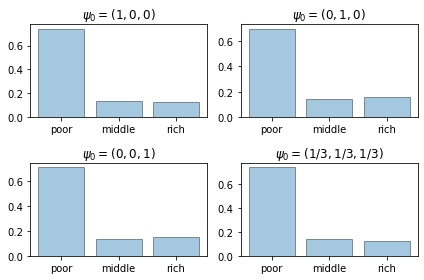

In [5]:
initial_dists = ((1, 0, 0),
                 (0, 1, 0),
                 (0, 0, 1),
                 (0.33, 0.33, 0.34))

titles = ('$\\psi_0 = (1, 0, 0)$', 
          '$\\psi_0 = (0, 1, 0)$',
          '$\\psi_0 = (0, 0, 1)$',
          '$\\psi_0 = (1/3, 1/3, 1/3)$')

fig, axes = plt.subplots(2, 2)
axes = axes.flatten()

for psi, title, ax in zip(initial_dists, titles, axes):
    generate_plot(psi, title, ax)

plt.tight_layout()
plt.show()


Finally, here is a histogram of states produced by a single very long time
series.

For large samples, the histogram is essentially identical to the ones we
produced above.

This is ergodicity.

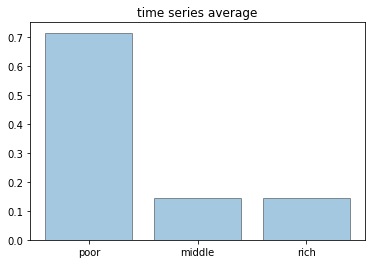

In [6]:
sim_length = 100_000
draws = mc.simulate(sim_length, init=0)
histogram = [np.mean(draws == i) for i in range(3)]

fig, ax = plt.subplots()
names = 'poor', 'middle', 'rich'
ax.bar(names, histogram, edgecolor='k', alpha=0.4)
ax.set_title('time series average')

plt.show()


Here is the code that produced the lattice figure in chapter 1.

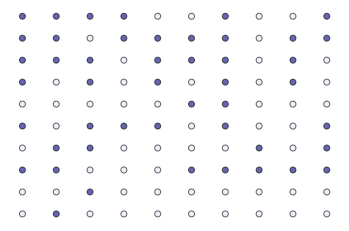

In [7]:
xx, yy = np.meshgrid(np.arange(10), np.arange(10), indexing='ij')


cols = np.random.randint(0, high=2, size=100)

cmap = ListedColormap(('lavender', 'navy'))

fig, ax = plt.subplots()
plt.axis('off')
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.scatter(xx,yy, c=cols, cmap=cmap, alpha=0.6, edgecolor='k')
plt.show()


## The Schelling Model

Next I provide the code for the Schelling model simulations.


I omit most explanations.

Hopefully readers will find the code transparent after building some
experience reading other chapters.

In [8]:
n = 1000                # number of agents (agents = 0, ..., n-1)
k = 10                  # number of agents regarded as neighbors
require_same_type = 5   # want >= require_same_type neighbors of the same type

def initialize_state():
    locations = uniform(size=(n, 2))
    types = randint(0, high=2, size=n)   # label zero or one
    return locations, types

@njit
def compute_distances_from_loc(loc, locations):
    " Compute distance from location loc to all other points. "
    distances = np.empty(n)
    for j in range(n):
        distances[j] = np.linalg.norm(loc - locations[j, :])
    return distances

def get_neighbors(loc, locations):
    " Get all neighbors of a given location. "
    all_distances = compute_distances_from_loc(loc, locations)
    indices = np.argsort(all_distances)   # sort agents by distance to loc
    neighbors = indices[:k]               # keep the k closest ones
    return neighbors

def is_happy(i, locations, types):
    happy = True
    agent_loc = locations[i, :]
    agent_type = types[i]
    neighbors = get_neighbors(agent_loc, locations)
    neighbor_types = types[neighbors]
    if sum(neighbor_types == agent_type) < require_same_type:
        happy = False
    return happy

def count_happy(locations, types):
    " Count the number of happy agents. "
    happy_sum = 0
    for i in range(n):
        happy_sum += is_happy(i, locations, types)
    return happy_sum
    
def update_agent(i, locations, types):
    " Move agent if unhappy. "
    moved = False
    while not is_happy(i, locations, types):
        moved = True
        locations[i, :] = uniform(), uniform()
    return moved

def plot_distribution(locations, types, title, savepdf=False):
    " Plot the distribution of agents after cycle_num rounds of the loop."
    fig, ax = plt.subplots()
    colors = 'lavender', 'navy'
    for agent_type, color in zip((0, 1), colors):
        idx = (types == agent_type)
        ax.plot(locations[idx, 0], 
                locations[idx, 1], 
                'o', 
                markersize=8,
                markerfacecolor=color, 
                alpha=0.8)
    ax.set_title(title)
    if savepdf:
        plt.savefig(title + '.pdf')
    plt.show()


def sim_sequential(max_iter=100):
    """
    Simulate by sequentially stepping through the agents, one after
    another.

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter < max_iter:
        print("Entering iteration ", current_iter)

        plot_distribution(locations, types, f'cycle_{current_iter}')

        # Update all agents
        num_moved = 0
        for i in range(n):
            num_moved += update_agent(i, locations, types)

        if num_moved == 0:
            print(f"Converged at iteration {current_iter}")
            break

        current_iter += 1


def sim_random_select(max_iter=100_000, flip_prob=0.01, test_freq=10_000):
    """
    Simulate by randomly selecting one household at each update.

    Flip the color of the household with probability `flip_prob`.

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter <= max_iter:

        # Choose a random agent and update them
        i = randint(0, n)
        moved = update_agent(i, locations, types)

        if flip_prob > 0: 
            # flip agent i's type with probability epsilon
            U = uniform()
            if U < flip_prob:
                current_type = types[i]
                types[i] = 0 if current_type == 1 else 1

        # Every so many updates, plot and test for convergence
        if current_iter % test_freq == 0:   
            cycle = current_iter / n
            plot_distribution(locations, types, f'iteration {current_iter}')
            if count_happy(locations, types) == n:
                print(f"Converged at iteration {current_iter}")
                break

        current_iter += 1

    if current_iter > max_iter:
        print(f"Terminating at iteration {current_iter}")



This code creates figures 1.6 -- 1.7, modulo randomness.

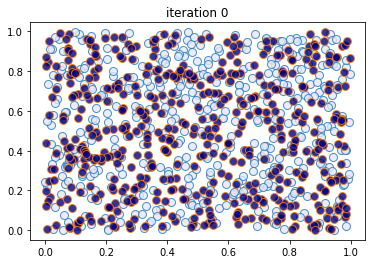

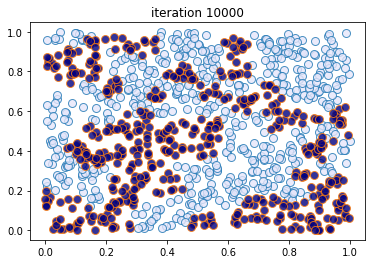

Converged at iteration 10000


In [9]:
sim_random_select(max_iter=50_000, flip_prob=0.0, test_freq=10_000)


This code creates figures 1.8 -- 1.9.

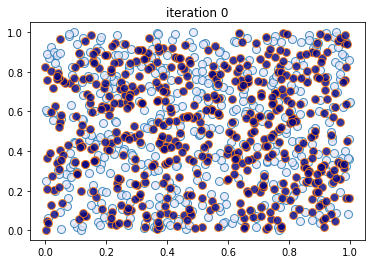

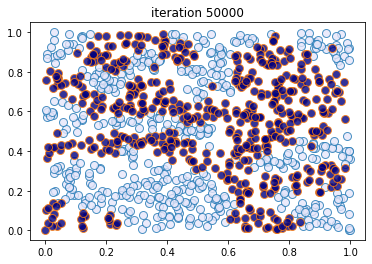

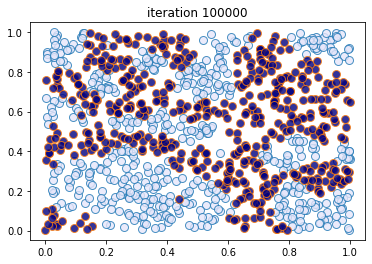

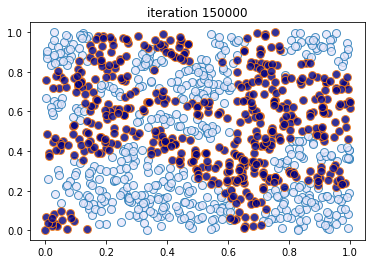

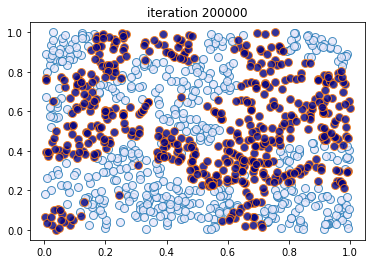

Terminating at iteration 200001


In [10]:
sim_random_select(max_iter=200_000, flip_prob=0.01, test_freq=50_000)


## Linear AR(1) Simulation

In this section we generate the time path figures for the Gaussian AR(1) model
(figures 1.10, 1.12 and 1.13).

In [11]:
a = 0.9
b = 1.0

mu_0, v_0 = 1, 1

def compute_mean_and_var(t):
    mu, v = mu_0, v_0
    for i in range(t):
        mu = a * mu + b
        v = a**2 * v + 1

    return mu, v

def norm_pdf(x, mu, v):
    return np.sqrt(1/(2 * np.pi * v)) * np.exp(-(x - mu)**2 / (2*v))


Here is the density sequence.

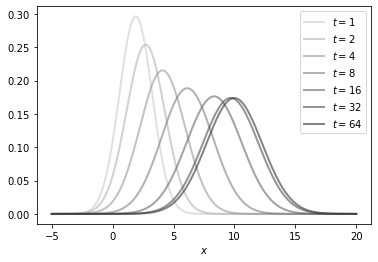

In [12]:
dates = 1, 2, 4, 8, 16, 32, 64
y_grid = np.linspace(-5, 20, 200)
greys = [str(g) for g in np.linspace(0.2, 0.8, len(dates))]
greys.reverse()

fig, ax = plt.subplots()

for t, g in zip(dates, greys):
    mu, v = compute_mean_and_var(t)
    ax.plot(y_grid, 
            [norm_pdf(y, mu, v) for y in y_grid], 
            color=g, 
            lw=2, 
            alpha=0.6,
            label=f'$t={t}$')

ax.set_xlabel('$x$')
ax.legend()

plt.show()



Here is the time series.

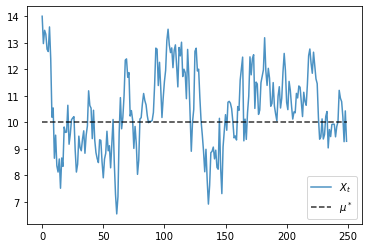

In [13]:
def generate_time_series(X_0=14, ts_length=250):
    X = np.empty(ts_length)
    X[0] = X_0
    for t in range(ts_length-1):
        X[t+1] = a * X[t] + b + np.random.randn()
    return X

mu_star = b / (1 - a)

X = generate_time_series()

fig, ax = plt.subplots()

ax.plot(X, label='$X_t$', alpha=0.8)
ax.plot(np.full(len(X), mu_star), 'k--', label='$\\mu^*$', alpha=0.8)

ax.legend()

plt.show()



Finally, here is the evolution of the mean.

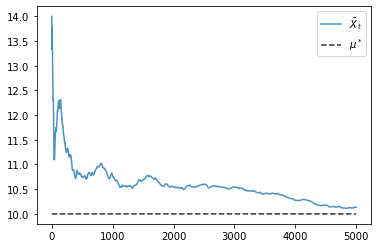

In [14]:

X = generate_time_series(ts_length=5000)
X_bar_series = np.cumsum(X) / np.arange(1, len(X)+1)

fig, ax = plt.subplots()

ax.plot(X_bar_series, label='$\\bar X_t$', alpha=0.8)
ax.plot(np.full(len(X_bar_series), mu_star), 'k--', label='$\\mu^*$', alpha=0.8)

ax.legend()
plt.show()
